In [1]:
# GPM 3B-CMB reading, first attempt Aug 2018
# cleaned up code before submission of manuscript, mid dec 2018 dduncan
# (code produces 2pan 3d plots of Dm and Nw comparing OceanRAIN and GPM CMB, Fig 2 in manuscript)
# revisited briefly 21/1/19 just to print some values and a sanity check, nothing really changed.
# revisit in mid march for paper revisions:
# -- adding dm vs. nw plot, changing the latitudinal histogram plots into a 'joyplot'

import h5py
import glob
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
import cartopy.crs as ccrs


In [2]:
dire = '/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM'

# for filespec details, best to go here (page 1947): https://pps.gsfc.nasa.gov/Documents/filespec.GPM_V5.pdf

gver = '06' # have V05A, V06A
cmb_files = glob.glob(dire+'/3B_CMB/*V'+gver+'A.HDF5') # v05 before, now with v06 (mar 2019)
day_files = glob.glob(dire+'/3B_CMB_DAY/*V06A.HDF5') # v06


In [3]:
# make low-res and high-res grids for multimonth means, weighted by counts per month so as to be fair
# low res grid goes 70S to 70N, high res grid goes 67S to 67N
xl,yl = 72,28
xh,yh = 1440,536  # things don't look markedly different in hi-res product, just noisier and takes longer

nb = 30 
# 3B_CMB histogram bins for Dm:
binz = np.append(np.arange(0.1,3.01,0.1),4.0)[0:nb]
print(binz,len(binz))

# unitless, for n(D) in m^-4
nbnz = np.array([4.0,    4.2,    4.4,    4.6,    4.8,    5.0,     \
              5.2,    5.4,    5.6,    5.8,    6.0,    6.2,     \
              6.4,    6.6,    6.8,    7.0,    7.2,    7.4,     \
              7.6,    7.8,    8.0,    8.2,    8.4,    8.6,  \
              8.8,    9.0,    9.2,    9.4,    9.6,    10.0 ])
# shift from m^-4 to mm^-1 m^-3:
nbnz -= 3
print(nbnz,len(nbnz))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ] 30
[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4
 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 7. ] 30


In [4]:
# quantify the density of OR obs within level 3 monthly grid boxes
typ = 'M4' #Ss3'
dir_raw_data = "/home/dudavid/projects/dsd/dj/data/"
olo = np.load(dir_raw_data+'alllond'+typ+'.npy')# [::per]
ola = np.load(dir_raw_data+'alllatd'+typ+'.npy')# [::per]
odate = np.load(dir_raw_data+'alldatd'+typ+'.npy')# [::per] # date: DDMMYYYY
or_dm = np.load(dir_raw_data+'alldmd'+typ+'.npy')
or_nw = np.log10(np.load(dir_raw_data+'allnwd'+typ+'.npy'))
print(info(or_nw))

months = np.array([int(str(x)[-5:-7:-1][::-1])-1 for x in odate]) # month indices starting at 0 for jan
print(np.shape(months))
dgrid = np.zeros([xl,yl,12])
startlat, gsize = 70, 5
ladex = np.round((ola[:]+startlat-gsize*.5) / gsize)
lodex = np.round((olo[:]+180.0-gsize*.5) / gsize)
grid_lats = np.arange(-startlat,startlat+.1,gsize)
grid_lons = np.arange(-180,180.1,gsize)
print(info(ladex))
for t in range(12):
    tsub = np.where( months == t)#[0]
    #print(len(odate[tsub]))
    for x in range(xl):
        if np.any(lodex[tsub] == x):
            dexsub = np.where(lodex[tsub] == x)
            #subsetla = ladex[tsub][dexsub]
            for y in range(yl):
                if np.any(ladex[tsub][dexsub] == y):
                    lolasubset = np.where(ladex[tsub][dexsub] == y)
                    dgrid[x,y,t] += len(ladex[tsub][dexsub][lolasubset])
ct_grid = np.sum(dgrid, axis=2)
print(ct_grid.shape)
#gcartomap(np.transpose(np.sum(dgrid[:,:,:],axis=2)),np.arange(-180,180, 1, 1.5e3, 1)
#grdmap(np.transpose(np.sum(dgrid[:,:,:],axis=2)),-180,-70, 1, 1.5e3, 1)


['1.70E-2', '6.06E+0', '3.70E+0', '6.82E-1']
(92116,)
['0.00E+2', '3.00E+1', '1.43E+1', '8.91E+0']
(72, 28)


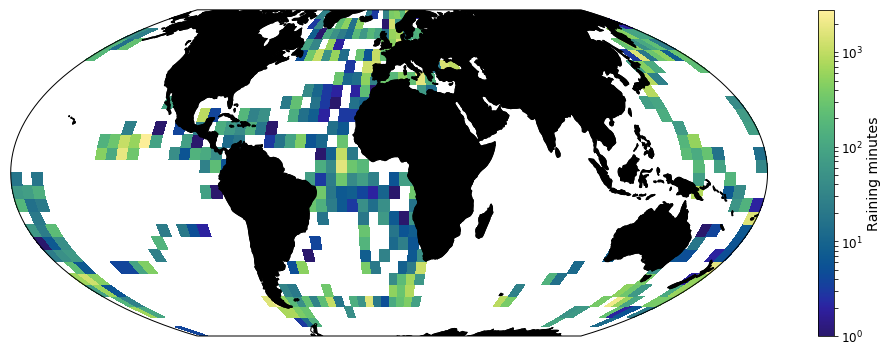

In [5]:
from cmocean import cm as cmo
import matplotlib.colors as colors
projj=ccrs.Mollweide() #PlateCarree()
thenorm = colors.LogNorm(vmin=1,vmax=ct_grid.max())
dcm = cmo.haline
f, ax = plt.subplots(1,1, subplot_kw=dict(projection=projj), figsize=[18,6])
#inn = 0 # try shrinking lat range shown?
#dens = ax.pcolormesh(grid_lons, grid_lats[inn:-inn], ct_grid[:,inn:-inn].transpose(),
dens = ax.pcolor(grid_lons, grid_lats[:], ct_grid[:,:].transpose(),
            norm=thenorm, transform=ccrs.PlateCarree(), cmap=dcm)
ax.coastlines(resolution='110m');
sm = plt.cm.ScalarMappable(cmap=dcm, norm=thenorm)
sm._A = []
cb = plt.colorbar(sm,ax=ax)
cb.set_label('Raining minutes',size=14)
cb.ax.tick_params(labelsize=12)

import cartopy.feature as cfeature
land = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                          edgecolor='k', facecolor='k')
ax.add_feature(land)

f.savefig('img/OR_counts_map_v1.png',dpi=320,bbox_inches='tight',transparent=True)

###  PDFs of Nw vs. Dm for OR and GPM

In [64]:
# same as below for monthly gridded data, but for daily:

# arrays are "st,rt,hgt,ns,lnL,ltL" where st= sfc type (ocean,land,all), 
#   rt= rain type (str/conv/all), hgt= alt. index (0=sfc,1-10=km levels, above are different), 
#   ns = # swaths (MS (ku+ka+gmi), NS (ku+gmi)), lnL= longitude Lo, ltL= latitude Lo
# G1 is 5deg boxes, G2 is 0.25deg boxes
st=0  #ocean/land/all
rt=2  #strat/conv/all
hgt=0 #near-sfc, otherwise km index
ns=0  #MS(0) or NS(1) swath of DPR -- reminder: MS is Ku+Ka (middle swath), NS is Ku-only

daily_2dhisto = np.zeros_like(cs)
    
purr = 1
for fi in range(len(day_files))[::purr]: 
    #print(day_files[fi]) # to make sure they run in order!
    day_str = day_files[fi][-38:-30] # should be YYYYMMDD string
    print(day_str)
    if day_str != '20170928' and day_str != '20170927': # days of xcal maneuvers?
        f = h5py.File(day_files[fi])
        #g1 = f['Grids/G1']
        g2 = f['Grids/G2']
        #DmLo= np.array(g1['precipTotDm/hist'])[:,st,rt,hgt,ns,:,:]  #[nhis,st,rt,hgt,ns,:,:]
        #NwLo= np.array(g1['precipTotLogNw/hist'])[:,st,rt,hgt,ns,:,:]  #[nhis,st,rt,hgt,ns,:,:]
        DmHi= np.array(g2['precipTotDm/mean'])[rt,hgt,ns,:,:]  #[rt,hgt,ns,:,:]
        NwHi= np.array(g2['precipTotLogNw/mean'])[rt,hgt,ns,:,:]  #[rt,hgt,ns,:,:]
        dex = np.logical_and(DmHi>0, NwHi>0) # make sure both are defined
        hishers,hx,hy = np.histogram2d(DmHi[dex], (NwHi[dex]-3), bins=[binz,nbnz])#, normed=1)
        #  -3 as GPM has units of m^-4, want to have histo in mm^-1 m^-3
        daily_2dhisto += hishers
    
f.close()
            


20170101
20170102
20170103
20170104
20170105
20170106
20170107
20170108
20170109
20170110
20170111
20170112
20170113
20170114
20170115
20170116
20170117
20170118
20170119
20170120
20170121
20170122
20170123
20170124
20170125
20170126
20170127
20170128
20170129
20170130
20170131
20170201
20170202
20170203
20170204
20170205
20170206
20170207
20170208
20170209
20170210
20170211
20170212
20170213
20170214
20170215
20170216
20170217
20170218
20170219
20170220
20170221
20170222
20170223
20170224
20170225
20170226
20170227
20170228
20170301
20170302
20170303
20170304
20170305
20170306
20170307
20170308
20170309
20170310
20170311
20170312
20170313
20170314
20170315
20170316
20170317
20170318
20170319
20170320
20170321
20170322
20170323
20170324
20170325
20170326
20170327
20170328
20170329
20170330
20170331
20170401
20170402
20170403
20170404
20170405
20170406
20170407
20170408
20170409
20170410
20170411
20170412
20170413
20170414
20170415
20170416
20170417
20170418
20170419
20170420
20170421
2

['0.00E+2', '1.05E+6', '1.03E+4', '7.37E+4']
['0.00E+2', '1.21E-1', '1.19E-3', '8.47E-3']
1.0 1.0


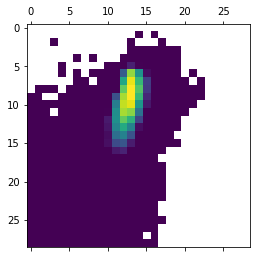

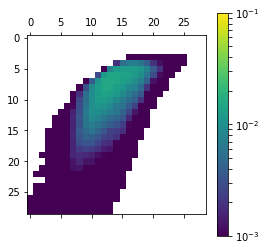

In [65]:
print(info(daily_2dhisto))
daily_2dhisto_normed = daily_2dhisto / np.sum(daily_2dhisto)
print(info(daily_2dhisto_normed))
plt.matshow(daily_2dhisto_normed, norm=colors.LogNorm(vmin=1e-3, vmax=.1))# , norm=LogNorm())
plt.matshow(cs/np.sum(cs), norm=colors.LogNorm(vmin=1e-3, vmax=.1))# , norm=LogNorm())
print(np.sum(cs/np.sum(cs)), np.sum(daily_2dhisto_normed))
plt.colorbar()

In [66]:
np.save('gpm_dailycmb_hi_'+str(purr)+'per_combined-histo',daily_2dhisto) # save histo just in case

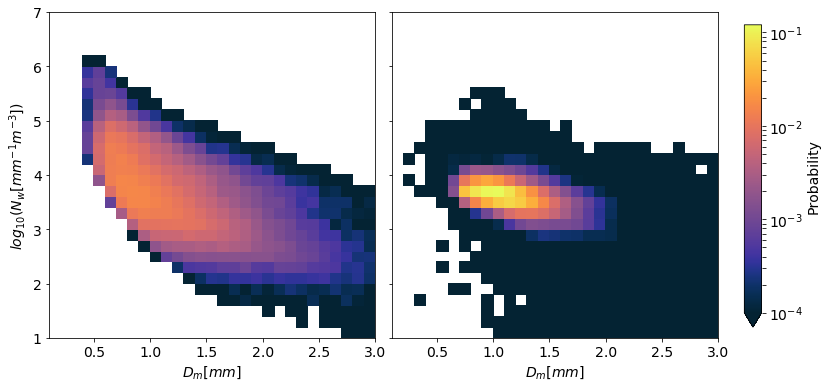

In [72]:

f,ax = plt.subplots(1,2,figsize=[12,6], sharex=True, sharey=True)
#ax[0].plot()
#ax[0].set_yscale("log")
#cs, xx, yy, img = plt.hist2d(or_dm, or_nw, bins=[100,70], range=[[0.5,3.0], [2,5.5]], 
#cs, xx, yy, img = plt.hist2d(np.sum(allhist,axis=1), np.sum(allhistnw,axis=1), bins=[binz,nbnz], 
zima = cmo.thermal
cs, xx, yy = np.histogram2d(or_dm, or_nw, bins=[binz,nbnz]) #, 
#cs, xx, yy, img = ax[0].hist2d(or_dm, or_nw, bins=[binz,nbnz], 
#                             cmap=zima,normed=1)
vmi, vma = 1e-4, np.max(daily_2dhisto_normed)#2e-1
bb  = ax[0].pcolor( xx, yy,        cs.transpose()/np.sum(cs), cmap=zima ,norm=colors.LogNorm(vmin=vmi, vmax=vma))
bb1 = ax[1].pcolor( xx, yy, daily_2dhisto_normed.transpose(), cmap=zima ,norm=colors.LogNorm(vmin=vmi, vmax=vma))
cbar_ax = f.add_axes([0.93, 0.15, 0.02, 0.7])
cb = f.colorbar(bb, cax=cbar_ax, orientation='vertical',norm=colors.LogNorm(vmin=vmi, vmax=vma), extend='min')
fs = 14
cb.set_label('Probability',fontsize=fs) #since normed to sum1, not a density
cb.ax.tick_params(labelsize=fs)
ax[0].grid(False)
ax[1].grid(False)
ax[0].set_xlabel('$D_m [mm]$', fontsize=fs)
ax[1].set_xlabel('$D_m [mm]$', fontsize=fs)
ax[0].set_ylabel('$log_{10} (N_w [mm^{-1} m^{-3}])$',fontsize=fs)
ax[0].tick_params(labelsize=fs,axis='both')
ax[1].tick_params(labelsize=fs,axis='both')
#ax[0].set_xticks(fontsize=fs)
#ax[0].set_yticks(fontsize=fs)
f.subplots_adjust(wspace=.05,hspace=0, right=.9)

f.savefig('img/GPM_OR_Dm-Nw_v1-'+str(purr)+'.png',dpi=320,bbox_inches='tight',transparent=True)
plt.show()

In [ ]:

# arrays are "st,rt,hgt,ns,lnL,ltL" where st= sfc type (ocean,land,all), 
#   rt= rain type (str/conv/all), hgt= alt. index (0=sfc,1-10=km levels, above are different), 
#   ns = # swaths (MS (ku+ka+gmi), NS (ku+gmi)), lnL= longitude Lo, ltL= latitude Lo
# G1 is 5deg boxes, G2 is 0.25deg boxes
st=0  #ocean/land/all
rt=2  #strat/conv/all
hgt=0 #near-sfc, otherwise km index
ns=0  #MS(0) or NS(1) swath of DPR -- reminder: MS is Ku+Ka (middle swath), NS is Ku-only

mlowdm, mlownw = np.zeros([xl,yl]),np.zeros([xl,yl])
mlowdm_up = np.zeros([xl,yl])
lowcD_up = np.zeros([xl,yl])
mhidm, mhinw = np.zeros([xh,yh]),np.zeros([xh,yh])
lowcD, lowcN = np.zeros([xl,yl]),np.zeros([xl,yl])
nlt = 6 #   number of lat bins
allhist = np.zeros([nb,nlt]) # 30 gpm-defined bins, lat bins 20deg each (60S-60N)
allhistnw = np.zeros([nb,nlt]) # 30 gpm-defined bins, lat bins 20deg each (60S-60N)
    
for fi in range(len(cmb_files)): 
    f = h5py.File(cmb_files[fi])
    print(cmb_files[fi]) # to make sure they run in order!
    g1 = f['Grids/G1']
    g2 = f['Grids/G2']
    DmLoH= np.array(g1['precipTotDm/hist'])[:,st,rt,hgt,ns,:,:]  #[nhis,st,rt,hgt,ns,:,:]
    NwLoH= np.array(g1['precipTotLogNw/hist'])[:,st,rt,hgt,ns,:,:]  #[nhis,st,rt,hgt,ns,:,:]
    for b in range(nb):
        # zero out the counts for grid boxes where OR didn't have observations:
        #scgrid = np.sum(dgrid[:,:,:],axis=2)
        scgrid = dgrid[:,:,fi]
        new_DmLoH = DmLoH[b,:,:]
        new_DmLoH[ scgrid == 0 ] = 0
        new_NwLoH = NwLoH[b,:,:]
        new_NwLoH[ scgrid == 0 ] = 0
        for y in range(nlt):    # hardcoded starting -60 (since grid starts -70), up by 20s
            allhist[b,y] += np.sum(new_DmLoH[:,(2+y*4):(2+(y+1)*4)]) # -60 to -40, -40 to -20, up to 80
            allhistnw[b,y] += np.sum(new_NwLoH[:,(2+y*4):(2+(y+1)*4)]) 
            #allhist[b,y] = np.sum(new_DmLoH[b,:,(2+y*4):(2+(y+1)*4)]) # -60 to -40, -40 to -20, up to 80
            #allhistnw[b,y] = np.sum(new_NwLoH[b,:,(2+y*4):(2+(y+1)*4)]) 
    print(np.sum(allhist[:,nlt-1]), fi)
    #f.close()
f.close()
            
#    DmLo = np.array(g1['precipTotDm/mean'])[st,rt,hgt,ns,:,:] # Dm is volume-weighted mean [mm]
#    DmLo_up = np.array(g1['precipTotDm/mean'])[st,rt,hgt+2,ns,:,:] 
#    DmLoC_up = np.array(g1['precipTotDm/count'])[st,rt,hgt+2,ns,:,:]
#    DmLoS= np.array(g1['precipTotDm/stdev'])[st,rt,hgt,ns,:,:]
#    DmLoC= np.array(g1['precipTotDm/count'])[st,rt,hgt,ns,:,:]
#    NwLo = np.array(g1['precipTotLogNw/mean'])[st,rt,hgt,ns,:,:] # Nw given as logNw [m^-4]
#    NwLoS= np.array(g1['precipTotLogNw/stdev'])[st,rt,hgt,ns,:,:]
#    NwLoC= np.array(g1['precipTotLogNw/count'])[st,rt,hgt,ns,:,:]
#    # high-res doesn't have land/ocean/all index:
#    #DmHi = np.array(g2['precipTotDm/mean'])[rt,hgt,ns,:,:] # Dm is volume-weighted mean [mm]
#    #DmHiS= np.array(g2['precipTotDm/stdev'])[rt,hgt,ns,:,:]
#    #DmHiC= np.array(g2['precipTotDm/count'])[rt,hgt,ns,:,:]
#    #NwHi = np.array(g2['precipTotLogNw/mean'])[rt,hgt,ns,:,:] # Nw given as logNw [m^-4]
#    #NwHiS= np.array(g2['precipTotLogNw/stdev'])[rt,hgt,ns,:,:]
#    #NwHiC= np.array(g2['precipTotLogNw/count'])[rt,hgt,ns,:,:]
#    # a good subset for these is [st=0,rt=2,hgt=0,ns=0,:,:]
#    
#    #print(np.min(NwLo),np.min(NwLoC)) # no negative #s to screen out
#    mlowdm[:,:] += DmLo*DmLoC #[DmLo>0] # sum up, divide later by counts
#    mlownw[:,:] += NwLo*NwLoC #[NwLo>0] 
#    mlowdm_up[:,:] += DmLo*DmLoC_up
#    
#    lowcD[:,:]  += DmLoC #[DmLoC>0]
#    lowcD_up[:,:]  += DmLoC_up #[DmLoC>0]
#    lowcN[:,:]  += NwLoC #[NwLoC>0]
#
#
#mlowdm[lowcD>0] /= lowcD[lowcD>0]
#mlownw[lowcN>0] /= lowcN[lowcN>0]
#mlowdm_up[lowcD_up>0] /= lowcD_up[lowcD_up>0]

In [ ]:
#print(shinfo(np.sum(allhist,axis=1)))
#print(shinfo(np.sum(allhistnw,axis=1)))
#f,ax = plt.subplots(1,1,figsize=[12,7])
##ax[0].plot()
##ax[0].set_yscale("log")
#from cmocean import cm as cmo
##cs, xx, yy, img = plt.hist2d(or_dm, or_nw, bins=[100,70], range=[[0.5,3.0], [2,5.5]], 
##cs, xx, yy, img = plt.hist2d(or_dm, or_nw, bins=[binz,nbnz], 
##cs, xx, yy, img = plt.hist2d(np.sum(allhist,axis=1), np.sum(allhistnw,axis=1), bins=[binz,nbnz], 
##                             cmap=cmo.thermal,normed=1)#,norm=LogNorm(vmin=3e-2, vmax=1))
#gpm_histo = np.histogram2d(np.sum(allhist,axis=1), np.sum(allhistnw,axis=1), bins=[binz,nbnz], normed=1)
#plt.pcolor(xx,yy, gpm_histo, cmap=cmo.thermal)
#cb = plt.colorbar()
#fs = 14
#cb.set_label('Probability density',fontsize=fs)
#cb.ax.tick_params(labelsize=fs)
#plt.xlabel('$D_m [mm]$',fontsize=fs)
#plt.ylabel('$log_{10} (N_w [mm^{-1} m^{-3}])$',fontsize=fs)
#plt.xticks(fontsize=fs)
#plt.yticks(fontsize=fs)
#plt.show()

In [ ]:
#print(allhistnw[:,0])

#print(100*allhistnw[:,4]/np.sum(allhistnw[:,4]))
#print(np.cumsum(np.sum(allhistnw[:,:],1))/np.sum(allhistnw[:,:]))
#print(nbnz)
#print(info(allhist))
#print(info(allhistnw)) # doesnt say much, just histogram counts in gpm-defined bins
nhist = allhist
nhist_nw = allhistnw #np.zeros_like(allhistnw)  # normalize GPM histogram counts along each lat band
for y in range(nlt):
    if(np.sum(allhist[:,y])>0): nhist[:,y] /= np.sum(allhist[:,y])
    if(np.sum(allhistnw[:,y])>0): nhist_nw[:,y] /= np.sum(allhistnw[:,y])
#print(info(mlownw,0))
or_hist_dm = np.load('OR_7lat_Dm.npy')
or_hist_nw = np.load('OR_7lat_Nw.npy')
print(np.shape(or_hist_dm))
#print(nhist_nw[:,4])
print(info(nhist_nw))

## conclusion: Very little variability in Nw seen by 3B-CMB!!

In [ ]:
def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.3)
def ce(arg):
    return mcolors.to_rgba(arg, alpha=0.9)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
red_patch = mpatches.Patch(color=cc('b'), label='OceanRain')
blue_patch = mpatches.Patch(color=cc('r'),label='GPM Combined')

bznss = 20.0 # degrees lat
maxlat, minlat = 60, -60
ny = int((maxlat - minlat)/bznss)  # should match nlt above 

btwn=1
zs = []
for y in range(ny):
    zs.append(minlat+(y+.5)*bznss-btwn)
    zs.append(minlat+(y+.5)*bznss+btwn) # btwn to have 3d panels staggered a little, ie at 51 and 49 for 40-60


In [ ]:
#
## Dm first
#or_hist_dm[22:,nlt-1] = .007  # just a weird rendering thing... otherwise small values look negative on plot
plohist1 = np.zeros([nb-5,nlt*2])
plohist1[:,0:(2*nlt-1):2] = nhist[0:nb-5,:]
plohist1[:,1:(2*nlt):2] = or_hist_dm[0:nb-5,:nlt]
#    
#xs1 = binz[nb-5:0:-1] 
#verts1 = []
#for z in range(nlt*2):
#    ys1 = plohist1[::-1,z]*100.0
#    verts1.append(list(zip(xs1, ys1)))
#
#fig2 = plt.figure(figsize=[20,10]) #figsize=plt.figaspect(0.5))
#
#ax21 = fig2.add_subplot(1, 2, 1, projection='3d')
#poly1 = PolyCollection(verts1, facecolors=[cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b'), 
#                                         cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b')],
#                     edgecolors=[ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), 
#                                 ce('r'),ce('b'), ce('r'),ce('b')])
#poly1.set_alpha(0.2)
#ax21.add_collection3d(poly1, zs=zs, zdir='y')
#
#fs=15
#lapd = 13 # label pad, to keep from overlapping with tick labels
#ax21.set_xlabel('$D_m$ [$mm$]',fontsize=fs+2,labelpad=lapd)
#ax21.set_xlim3d(2.5, 0)
#ax21.set_ylabel('Latitude [$\degree$ N]',fontsize=fs+2,labelpad=lapd+2)
#ax21.set_ylim3d(minlat,maxlat)
#ax21.set_zlabel('Frequency [%]',fontsize=fs,labelpad=lapd)
#ax21.set_zlim3d(0.0, 12)
#ax21.view_init(elev=70.)
#ax21.tick_params(labelsize=fs,axis='both')

#plt.legend(handles=[red_patch,blue_patch],fontsize=fs+4, loc='upper right', frameon=False)

# And Nw
plohist2 = np.zeros([30-4,nlt*2])
plohist2[:,0:(nlt*2-1):2] = nhist_nw[0:(30-4),:]
plohist2[:,1:(nlt*2):2] = or_hist_nw[0:(30-4),:nlt]
#plt.tight_layout()
    
#xs2 = nbnz[0:30-4][::-1] 
#print(xs2)
#verts2 = []
#for z in range(nlt*2):
#    ys2 = plohist2[::-1,z]*100.0
#    verts2.append(list(zip(xs2, ys2)))
#
##fig2 = plt.figure(figsize=[10,10])
#ax22 = fig2.add_subplot(1, 2, 2, projection='3d')
#poly2 = PolyCollection(verts2, facecolors=[cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b'), 
#                                         cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b')],
#                     edgecolors=[ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), 
#                                 ce('r'),ce('b'), ce('r'),ce('b')])
#poly2.set_alpha(0.2)
#ax22.add_collection3d(poly2, zs=zs, zdir='y')
#
#ax22.set_xlabel('$log_{10}(N_W)$  [$mm^{-1} m^{-3}$]',fontsize=fs+2,labelpad=lapd)
#ax22.set_xlim3d(np.max(nbnz)-1, np.min(nbnz))
#ax22.set_ylabel('Latitude [$\degree$ N]',fontsize=fs+2,labelpad=lapd+2)
#ax22.set_ylim3d(minlat,maxlat)
#ax22.set_zlabel('Frequency [%]',fontsize=fs,labelpad=lapd)
#ax22.set_zlim3d(0.01, 30)
#ax22.view_init(elev=70.)
#ax22.tick_params(labelsize=fs,axis='both')
##plt.legend(handles=[red_patch,blue_patch],fontsize=fs-1,loc='upper left')
#
#plt.tight_layout()
#
##fig2.savefig('img/2pan_3d_GPMcmb_v3.png',dpi=200,bbox_inches="tight")
#
#plt.show()
##andstophere

In [ ]:
#
#or_hist_dm[22:,nlt-1] = .007  
# # just a weird graphics rendering thing... otherwise small values look negative on plot
#plohist = np.zeros([nb,nlt*2])
#plohist[:,0:(2*nlt-1):2] = nhist
#plohist[:,1:(2*nlt):2] = or_hist_dm[:,:nlt]
#print(or_hist_dm[:,nlt-1])
##andstop
##verts[verts < .5] = 0.0 # make it easier on plotting routine
#print(plohist[:,0])
#    
#xs = binz[::-1] 
#verts = []
#for z in range(2*nlt):
#    ys = plohist[::-1,z]*100.0 #np.random.rand(len(xs))
#    verts.append(list(zip(xs, ys)))
#
#fig = plt.figure(figsize=[10,10])
#ax = fig.gca(projection='3d')
#poly = PolyCollection(verts, facecolors=[cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b'), 
#                                         cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b')],
#                     edgecolors=[ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), 
#                                 ce('r'),ce('b'), ce('r'),ce('b')])
#poly.set_alpha(0.2)
#ax.add_collection3d(poly, zs=zs, zdir='y')
#
#fs = 14
#ax.set_xlabel('$D_m$ [mm]',fontsize=fs)
#ax.set_xlim3d(3, 0)
#ax.set_ylabel('Latitude [$\degree$ N]',fontsize=fs)
#ax.set_ylim3d(minlat,maxlat)
#ax.set_zlabel('Frequency [%]',fontsize=fs)
#ax.set_zlim3d(0.0, 12)
#ax.view_init(elev=70.)#,azim=0) # adjust elevation and azimuth angles for 3d plot view
#
#plt.legend(handles=[red_patch,blue_patch],fontsize=fs-1,loc='upper left')
#
##fig.savefig('img/3d_GPMcmb_Dm_v3.png',dpi=350,bbox_inches="tight")
#
#plt.show()

In [ ]:
## putting together to make into a 2 panel figure
#or_hist_dm[22:,nlt-1] = .007  
# # just a weird graphics rendering thing... otherwise small values look negative on plot
#plohist = np.zeros([nb,nlt*2])
#plohist[:,0:(2*nlt-1):2] = nhist
#plohist[:,1:(2*nlt):2] = or_hist_dm[:,:nlt]
#print(or_hist_dm[:,nlt-1])
##andstop
##verts[verts < .5] = 0.0 # make it easier on plotting routine
#print(plohist[:,0])
#    
#xs = binz[::-1] 
#verts = []
#for z in range(2*nlt):
#    ys = plohist[::-1,z]*100.0 #np.random.rand(len(xs))
#    verts.append(list(zip(xs, ys)))
#
#fig = plt.figure(figsize=[10,10])
#ax = fig.gca(projection='3d')
#poly = PolyCollection(verts, facecolors=[cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b'), 
#                                         cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b')],
#                     edgecolors=[ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), 
#                                 ce('r'),ce('b'), ce('r'),ce('b')])
#poly.set_alpha(0.2)
#ax.add_collection3d(poly, zs=zs, zdir='y')
#
#fs = 14
#ax.set_xlabel('$D_m$ [mm]',fontsize=fs)
#ax.set_xlim3d(3, 0)
#ax.set_ylabel('Latitude [$\degree$ N]',fontsize=fs)
#ax.set_ylim3d(minlat,maxlat)
#ax.set_zlabel('Frequency [%]',fontsize=fs)
#ax.set_zlim3d(0.0, 12)
#ax.view_init(elev=70.)#,azim=0) # adjust elevation and azimuth angles for 3d plot view
#
#plt.legend(handles=[red_patch,blue_patch],fontsize=fs-1,loc='upper left')
#
##fig.savefig('img/3d_GPMcmb_Dm_v3.png',dpi=350,bbox_inches="tight")
#
#plt.show()

In [ ]:
# change the 3D plot into a 'joyplot'
import seaborn as sns
def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.4)
#pal_g = cc('r') #sns.cubehelix_palette(nlt, start = 0)#chs)
#pal_o = cc('b') #sns.cubehelix_palette(nlt, start = 2)#chs)

blue_patch = mpatches.Patch(color=cc('b'), label='OceanRain')
red_patch  = mpatches.Patch(color=cc('r'), label='GPM CORRA') #ombined')

zsp = .2
z = np.linspace(0, zsp*nlt, nlt)
z1, z2 = z,z # np.linspace(0, .2*nlt, nlt), np.linspace(0,.25*nlt,nlt)
f, (axd, axn) = plt.subplots(1,2,figsize=[15,7], sharey=True)
axd.axis('on')
print(plohist1.shape,plohist2.shape) #, xs, ys)
x1 = binz[:nb-5]   # one is 25
x2 = nbnz[0:30-4] # the other 26
outc = "black"
fs = 15
axd.patch.set_facecolor("white")
axn.patch.set_facecolor("white")
for i in range(nlt-1, -1, -1):
    y_0 = z1[i]
    y_1 = plohist1[:, i*2] + y_0  # set up positioning of each row?
    axd.plot(x1, y_1, c = outc, zorder = -i)
    colo,colg = cc('b'),cc('r')  # or choose palettes here? -- make match the above
    axd.fill_between(x1, y_1, y_0,     zorder = -i, color=colg)
    axd.plot(x1, y_0*np.ones(x1.size), zorder = -i, color=colg)
    y_1 = plohist1[:, i*2+1] + y_0  # set up positioning of each row?
    axd.plot(x1, y_1, c = outc, zorder = -i)
    axd.fill_between(x1, y_1, y_0,     zorder = -i, color=colo)
    axd.plot(x1, y_0*np.ones(x1.size), zorder = -i, color=colo) 
    
    y_0 = z2[i]
    y_1 = plohist2[:, i*2] + y_0  # set up positioning of each row?
    axn.plot(x2, y_1, c = outc, zorder = -i)
    axn.fill_between(x2, y_1, y_0,     zorder = -i, color=colg)
    axn.plot(x2, y_0*np.ones(x2.size), zorder = -i, color=colg)
    y_1 = plohist2[:, i*2+1] + y_0  # set up positioning of each row?
    axn.plot(x2, y_1, c = outc, zorder = -i)
    axn.fill_between(x2, y_1, y_0,     zorder = -i, color=colo)
    axn.plot(x2, y_0*np.ones(x2.size), zorder = -i, color=colo)
#axd.legend(fontsize=fs)
#axd.legend(handles=[blue_patch,red_patch],fontsize=fs, loc='upper right', frameon=False)
axn.legend(handles=[blue_patch,red_patch],fontsize=fs, loc='upper left', frameon=False)
axd.grid(False)
axd.set_yticks(z1)
ytee = ['60S-40S','40S-20S','20S-Eq','Eq-20N','20N-40N','40N-60N']
axd.set_yticklabels(ytee, fontsize=fs)
axn.grid(False)
axd.tick_params(axis='x',labelsize=fs)
axn.tick_params(axis='x',labelsize=fs)
axn.set_yticks(z2+zsp/2)
axn.set_yticklabels(ytee, fontsize=fs)
axd.set_ylim([0,max(z1)+2.2*zsp])
axn.set_ylim([0,max(z2)+2.2*zsp])
axd.set_xlabel('$D_m [mm]$',fontsize=fs)
axn.set_xlabel('$log_{10}(N_w [mm^{-1} m^{-3}])$',fontsize=fs)
#axn.spines['top'].set_color("black")
#axn.spines['top'].set_visible(True)
plt.tight_layout()
f.savefig('img/joy_GPMcmb-MS'+str(ns)+'-sca'+str(rt)+'_2pan_v'+gver+'-1.png',dpi=350,bbox_inches="tight")
plt.show()

In [ ]:
#
#print(np.shape(NwLo))
#print(NwLo[13,13])
#print(NwLoH[:,13,13])
#print(nbnz)
#
#print(info(mlowdm,0))
##print(info(DmLoS,0))
##plt.figure(figsize=[12,7])
##grdmap(np.transpose(DmLoS),-180,-70, 0, 0.6, 0) # just last month in loop, for example
#plt.figure(figsize=[12,7])
#grdmap(np.transpose(mlowdm),-180,-70, 0.9, 1.5, 0)
#
## conclusion: Less variability in Nw is seen by 3B-CMB!! (compared to OceanRAIN anyway)

In [ ]:
## can also look at the difference in either Dm or Nw as they change with height 
##  (taken with a grain of salt, of course)
##hsub = 2 # i.e. 1-2km level
##dmdif = DmLo[0,2,0,0,:,:] - DmLo[0,2,hsub,0,:,:] # near-sfc minus 1-2km
##Nwdif = NwLo[0,2,0,0,:,:] - NwLo[0,2,hsub,0,:,:] # near-sfc minus 1-2km
#dmdif = mlowdm_up - mlowdm
#print(info(dmdif,0))
##plt.figure(figsize=[12,8])
##grdmap(np.transpose(dmdif),-180,-70,-.1,.1,2)
##grdmap(np.transpose(Nwdif),-180,-70,-.25,.25,2)